*Disclaimer: This example is from 09. Numerical Optimization in Data Science in Julia(Julia Academy).*

You can find many more interesting examples from JuliaAcademy/DataScience: https://github.com/JuliaAcademy/DataScience

In [1]:
import Pkg

In [2]:
using Pkg
#Pkg.add("Convex")
using Convex
#Pkg.add("SCS")
using SCS
#Pkg.add("XLSX")
using XLSX
#Pkg.add("DataFrames")
using DataFrames
#Pkg.add("Plots")
using Plots
#Pkg.add("CSV")
using CSV
#Pkg.add("Statistics")
using Statistics
#Pkg.add("Images")
using Images
#Pkg.add("DelimitedFiles")
using DelimitedFiles

## Example1: Portfolio investment

Our first problem will be an investment problem. We will look at stock prices from three companies and decide how to spend an amount of $1000 on these three companies. Let's first load some data.

In [4]:
T = DataFrame(XLSX.readtable("/Users/sowonjeong/julia-tutorial/data/stock_prices.xlsx","Sheet2"))

Row,MSFT,FB,AAPL
,Any,Any,Any
1,101.93,137.95,148.26
2,102.8,143.8,152.29
3,107.71,150.04,156.82
4,107.17,149.01,157.76
5,102.78,165.71,166.52
6,105.67,167.33,170.41
7,108.22,162.5,170.42
8,110.97,161.89,172.97
9,112.53,162.28,174.97


`T` is a `DataFrame` that has weekly stock prices value of three companies (Microsoft, Facebook, Apple) from the period of January 2019 - March 2019. We will first take a quick look at these prices in a quick plot

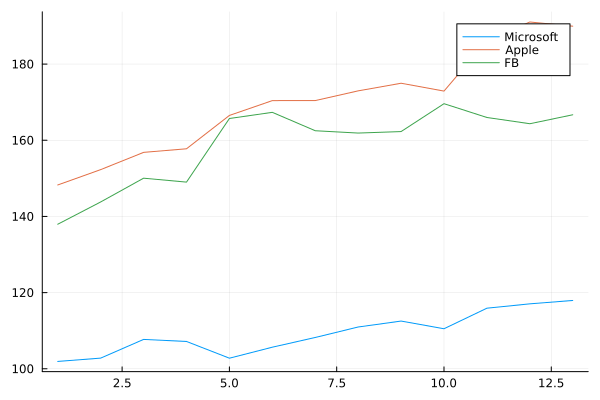

In [5]:
plot(T[!,:MSFT],label="Microsoft")
plot!(T[!,:AAPL],label="Apple")
plot!(T[!,:FB],label="FB")

In [6]:
# convert the prices to a Matrix to be used later in the optimization problem
prices_matrix = Matrix(T)

13×3 Matrix{Any}:
 101.93  137.95  148.26
 102.8   143.8   152.29
 107.71  150.04  156.82
 107.17  149.01  157.76
 102.78  165.71  166.52
 105.67  167.33  170.41
 108.22  162.5   170.42
 110.97  161.89  172.97
 112.53  162.28  174.97
 110.51  169.6   172.91
 115.91  165.98  186.12
 117.05  164.34  191.05
 117.94  166.69  189.95

To compute the weekly return, we will use the formula: `R[i,t] = (price[i,t] - price[i,t-1])/price[i,t-1]`. This is the return of stock `i` from week `t`.

In [7]:
M1 = prices_matrix[1:end-1,:]
M2 = prices_matrix[2:end,:]
R = (M2.-M1)./M1

12×3 Matrix{Float64}:
  0.00853527   0.0424067    0.027182
  0.0477626    0.0433936    0.0297459
 -0.00501346  -0.00686484   0.00599413
 -0.040963     0.112073     0.0555274
  0.0281183    0.00977611   0.0233606
  0.0241317   -0.0288651    5.8682e-5
  0.0254112   -0.00375385   0.014963
  0.0140579    0.00240904   0.0115627
 -0.0179508    0.0451072   -0.0117734
  0.0488644   -0.0213443    0.0763981
  0.00983522  -0.00988071   0.0264883
  0.00760359   0.0142996   -0.00575766

Now let's assume that the vector `x = [x1 x2 x3]` will contain the total number of dollars we will invest in these companies, i.e. `x1` is how much we will invest in the first company (MSFT), `x2` is how much we will invest in FB, and `x3` is how much we will invest in AAPL. The return on the investment will be `dot(r,x)`, where `r = [r1 r2 r3]` is the return from each of the companies.

Here, `r` is a random variable and we will have to model it in terms of expected values. And the expected value `E(dot(r,x))` will be `E[dot(mean(R,dims=2),x)`. If we want a return of 10% or more, then we need `dot(r,x) >= 0.1`.

Next, we will model the risk matrix. We will skip the derivation of the risk matrix here, but you can read about it here: https://www.kdnuggets.com/2019/06/optimization-python-money-risk.html. The risk matrix will be the covariance matrix of the computed return prices (`R`).

In [8]:
risk_matrix = cov(R)

3×3 Matrix{Float64}:
  0.000659383  -0.000630653  0.000139112
 -0.000630653   0.00152162   0.000192288
  0.000139112   0.000192288  0.000635503

In [9]:
# note that the risk matrix is positive definite
isposdef(risk_matrix)

true

In [10]:
r = mean(R,dims=1)[:]

3-element Vector{Float64}:
 0.012532748705136572
 0.016563036855293173
 0.02114580465503291

Now let's solve the following problem: Someone gives you $1000 and tells you to spend them in the form of investment on these three compnaies such that you get a return of 2\% on what you spent.

The goal will be to minimize the risk, that is `x'*risk_matrix*x`. The constraints will be

* `sum(x) = 1`, we will compute the percentage of investment rather than the exact amount
* `dot(r,x) >= 0.02`, set minimum return
* `x[i] >= 0`, assume no short position

This problem is a convext problem, and we will use `Convex.jl` to it.

In [11]:
x = Variable(length(r))
problem = minimize(x'*risk_matrix*x,[sum(x)==1;r'*x>=0.02;x.>=0])

minimize
└─ * (Convex.NotDcp; real)
   ├─ * (affine; real)
   │  ├─ adjoint (affine; real)
   │  │  └─ …
   │  └─ 3×3 Matrix{Float64}
   └─ 3-element real variable (id: 348…424)
subject to
├─ == constraint (affine)
│  ├─ sum (affine; real)
│  │  └─ 3-element real variable (id: 348…424)
│  └─ 1
├─ >= constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ [0.0125327 0.016563 0.0211458]
│  │  └─ 3-element real variable (id: 348…424)
│  └─ 0.02
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 348…424)
│  └─ 0
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 348…424)
│  └─ 0
└─ >= constraint (affine)
   ├─ index (affine; real)
   │  └─ 3-element real variable (id: 348…424)
   └─ 0

status: `solve!` not called yet

┌ Warning: Expression not DCP compliant. Trying to solve non-DCP compliant problems can lead to unexpected behavior.
└ @ Convex /Users/sowonjeong/.julia/packages/Convex/ukggP/src/dcp.jl:25


Note the `Convex.NotDcp` in the answer above and the warning. `Convex.jl` requires that we pass Dcp compliant problem (Disciplined convex programming). Learn more about the DCP ruleset here: http://cvxr.com/cvx/doc/dcp.html

In [12]:
# make the problem DCP compliant
problem = minimize(Convex.quadform(x,risk_matrix),[sum(x)==1;r'*x>=0.02;x.>=0])

minimize
└─ * (convex; positive)
   ├─ 1
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0]
subject to
├─ == constraint (affine)
│  ├─ sum (affine; real)
│  │  └─ 3-element real variable (id: 348…424)
│  └─ 1
├─ >= constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ [0.0125327 0.016563 0.0211458]
│  │  └─ 3-element real variable (id: 348…424)
│  └─ 0.02
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 348…424)
│  └─ 0
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 348…424)
│  └─ 0
└─ >= constraint (affine)
   ├─ index (affine; real)
   │  └─ 3-element real variable (id: 348…424)
   └─ 0

status: `solve!` not called yet

In [13]:
solve!(problem, SCS.Optimizer)

------------------------------------------------------------------
	       SCS v3.2.0 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 6, constraints m: 14
cones: 	  z: primal zero / dual free vars: 2
	  l: linear vars: 5
	  q: soc vars: 7, qsize: 2
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct
	  nnz(A): 24, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.71e+01  1.00e+00  1.62e+01 -8.03e+00  1.00e-01  4.89e-05 
    75| 8.16e-05  1.46e-04  5.60e-05  5.56e-04  1.00e-01  1.28e-04 
----------------------

In [14]:
x

Variable
size: (3, 1)
sign: real
vexity: affine
id: 348…424
value: [0.06922834751660407, 0.11730158220227527, 0.8134695146542505]

In [15]:
sum(x.value)

0.9999994443731299

In [16]:
# return 
r'*x.value

1×1 adjoint(::Vector{Float64}) with eltype Float64:
 0.020011959361601165

In [17]:
x.value .* 1000

3×1 Matrix{Float64}:
  69.22834751660407
 117.30158220227527
 813.4695146542506

The conclusion is that we should invest **69.2USD in Microsoft, 117.3USD in Facebook, and 813.5USD in Apple**.

## Example 2: Diet Optimization

This is a common problem in Numerical Optimization, and you can find multiple references about it online. Here, we will use one of the examples in the `JuMP` package. Refer to this page for details: https://github.com/JuliaOpt/JuMP.jl/blob/master/examples/diet.jl.

In this porblem we are given constraints on the number of (minimum, maximum) number of calories, protein, fat, and sodium to consume. We will first build a JuMP container to store this information and pass it as constraints later.

In [18]:
# Pkg.add("JuMP")
# Pkg.add("GLPK")
using JuMP
using GLPK

In [19]:
category_data = JuMP.Containers.DenseAxisArray(
    [1800 2200;
     91   Inf;
     0    65;
     0    1779], 
    ["calories", "protein", "fat", "sodium"], 
    ["min", "max"])

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, ["calories", "protein", "fat", "sodium"]
    Dimension 2, ["min", "max"]
And data, a 4×2 Matrix{Float64}:
 1800.0  2200.0
   91.0    Inf
    0.0    65.0
    0.0  1779.0

You can think of this matrix as indexed by rows via the vector `["calories", "protein", "fat", "sodium"]`, and indexed by columns via the vector `["min", "max"]`. In fact, we can now checkout the values: category_data`["calories","max"]` or category_data`["fat","min"]`.

In [20]:
@show category_data["calories","max"] 
@show category_data["fat","min"]
;

category_data["calories", "max"] = 2200.0
category_data["fat", "min"] = 0.0


Next, we will encode some information about food data we have.

In [21]:
foods = ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza","salad", "milk", "ice cream"]

# we will use the same concept we used above to create an array indexed 
# by foods this time to record the cost of each of these items
cost = JuMP.Containers.DenseAxisArray(
    [2.49, 2.89, 1.50, 1.89, 2.09, 1.99, 2.49, 0.89, 1.59],
    foods)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza", "salad", "milk", "ice cream"]
And data, a 9-element Vector{Float64}:
 2.49
 2.89
 1.5
 1.89
 2.09
 1.99
 2.49
 0.89
 1.59

Next we will create a new matrix to encode the calories,protein, fat, and sodium present in each of these foods. This will be a matrix encoded by foods by rows, and `["calories", "protein", "fat", "sodium"]` by columns.

In [22]:
food_data = JuMP.Containers.DenseAxisArray(
    [410 24 26 730;
     420 32 10 1190;
     560 20 32 1800;
     380  4 19 270;
     320 12 10 930;
     320 15 12 820;
     320 31 12 1230;
     100  8 2.5 125;
     330  8 10 180], 
    foods, 
    ["calories", "protein", "fat", "sodium"])

@show food_data["chicken", "fat"]
@show food_data["milk", "sodium"]
;

food_data["chicken", "fat"] = 10.0
food_data["milk", "sodium"] = 125.0


And now, we will build the model.

In [23]:
# set up the model
model = Model(GLPK.Optimizer)

categories = ["calories", "protein", "fat", "sodium"]

# add the variables
@variables(model, begin
    # Variables for nutrition info
    category_data[c, "min"] <= nutrition[c = categories] <= category_data[c, "max"]
    # Variables for which foods to buy
    buy[foods] >= 0
end)

# Objective - minimize cost
@objective(model, Min, sum(cost[f] * buy[f] for f in foods))

# Nutrition constraints
@constraint(model, [c in categories],
    sum(food_data[f, c] * buy[f] for f in foods) == nutrition[c]
)

1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, ["calories", "protein", "fat", "sodium"]
And data, a 4-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 -nutrition[calories] + 410 buy[hamburger] + 420 buy[chicken] + 560 buy[hot dog] + 380 buy[fries] + 320 buy[macaroni] + 320 buy[pizza] + 320 buy[salad] + 100 buy[milk] + 330 buy[ice cream] = 0.0
 -nutrition[protein] + 24 buy[hamburger] + 32 buy[chicken] + 20 buy[hot dog] + 4 buy[fries] + 12 buy[macaroni] + 15 buy[pizza] + 31 buy[salad] + 8 buy[milk] + 8 buy[ice cream] = 0.0
 -nutrition[fat] + 26 buy[hamburger] + 10 buy[chicken] + 32 buy[hot dog] + 19 buy[fries] + 10 buy[macaroni] + 12 buy[pizza] + 12 buy[salad] + 2.5 buy[milk] + 10 buy[ice cream] = 0

In [24]:
And finally, all what's left to be done is to solve the problem

LoadError: syntax: extra token "finally" after end of expression

In [25]:
JuMP.optimize!(model)
term_status = JuMP.termination_status(model)
is_optimal = term_status == MOI.OPTIMAL
@show JuMP.primal_status(model) == MOI.FEASIBLE_POINT
@show JuMP.objective_value(model) ≈ 11.8288 atol = 1e-4

JuMP.primal_status(model) == MOI.FEASIBLE_POINT = true
JuMP.objective_value(model) ≈ 11.8288 = false
atol = 0.0001 = 0.0001


0.0001

And to actually look at the solution, we can look at the buy variable.

In [26]:
hcat(buy.data,JuMP.value.(buy.data))

9×2 Matrix{AffExpr}:
 buy[hamburger]  0.6045138888888888
 buy[chicken]    0
 buy[hot dog]    0
 buy[fries]      0
 buy[macaroni]   0
 buy[pizza]      0
 buy[salad]      0
 buy[milk]       6.9701388888888935
 buy[ice cream]  2.591319444444441